# 1. Behavior of ents

In [2]:
import os
import sys
sys.path.append('../examples')
sys.path.append('../jobs')
sys.path.append('../training_data')

from tqdm import trange

import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from generate_with_calibration import get_lookahead_entropies
from generate_with_entropy import sample_sequence, sample_sequence_batch

import logging
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [29]:
# setup cell

def set_seed(seed=42, n_gpu=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()

set_seed()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)
model.eval()

vocab_size = tokenizer.vocab_size

01/04/2020 23:06:26 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /u/myhu/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.085d5f6a8e7812ea05ff0e6ed0645ab2e75d80387ad55c1ad9806ee70d272f80
01/04/2020 23:06:26 - INFO - transformers.configuration_utils -   Model config {
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "finetuning_task": null,
  "initializer_range": 0.02,
  "is_decoder": false,
  "layer_norm_epsilon": 1e-05,
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "num_labels": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torchscript": false,
  "use_bf

In [30]:
string = '" It is a damaging blow , " International Cycling Union ( UCI ) president Pat McQuaid told Reuters .'

In [31]:
context = tokenizer.encode(string)
context = torch.tensor(context, dtype = torch.long, device=device).unsqueeze(0)

inputs = {'input_ids': context}
logits = model(**inputs)[0][:, -1, :]

lookahead_ents = get_lookahead_entropies(
                model = model,
                context = context[0],
                batch_size = 128,
                vocab_size = vocab_size,
                candidates = None,
                device = device
            ).cpu()

In [32]:
test = logits.detach().cpu().numpy()

In [33]:
sorted_lookahead = lookahead_ents[np.argsort(test[0])]

In [34]:
sorted_lookahead = sorted_lookahead.cpu().numpy()

In [35]:
sorted_lookahead = sorted_lookahead[::-1]

Text(0, 0.5, 'Lookahead entropy')

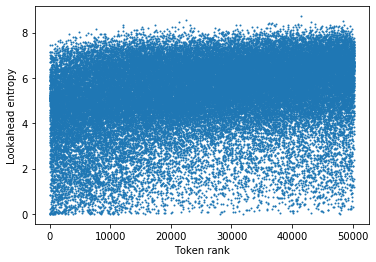

In [37]:
plt.scatter(range(len(sorted_lookahead)), sorted_lookahead, s=1)
plt.xlabel('Token rank')
plt.ylabel('Lookahead entropy')

In [28]:
np.corrcoef(range(len(sorted_lookahead)), sorted_lookahead)

array([[1.        , 0.26207401],
       [0.26207401, 1.        ]])

# 2. Temperature scaling

In [22]:
ents = np.load('../jobs/results/entropy-s1-temp-l200/result.npz')['avg_ents'][0]

In [14]:
ents

array([2.7665431, 3.5814228, 4.271414 , 4.1673174, 4.073349 , 4.0396805,
       3.9696183, 3.9492466, 3.936959 , 3.9241996, 3.9179077, 3.8662078,
       3.8894978, 3.8699632, 3.8863652, 3.8494346, 3.8676872, 3.861571 ,
       3.83516  , 3.8244517, 3.7999256, 3.8271892, 3.8452654, 3.8301885,
       3.8469627, 3.8268156, 3.8303387, 3.7942822, 3.8172126, 3.8571546,
       3.8207703, 3.8190887, 3.8141246, 3.8255253, 3.8252783, 3.7819037,
       3.8571641, 3.8056116, 3.8278239, 3.8251045, 3.8331878, 3.8302214,
       3.8166611, 3.8427765, 3.8471594, 3.8219068, 3.8421257, 3.8478851,
       3.8549104, 3.8616126, 3.8438904, 3.837956 , 3.8823423, 3.8346558,
       3.8510303, 3.8389165, 3.8588786, 3.8345835, 3.8682215, 3.879041 ,
       3.870749 , 3.8695366, 3.8741143, 3.8392236, 3.876227 , 3.866382 ,
       3.8892024, 3.8793023, 3.8806818, 3.8557737, 3.8549364, 3.863475 ,
       3.8689232, 3.8785179, 3.9512358, 3.8918638, 3.8947814, 3.8836613,
       3.8828819, 3.9145677, 3.9038408, 3.924047 , 

In [15]:
ents_temp = np.load('../jobs/results/entropy-s1-temp-l200-t09/result.npz')['avg_ents'][0]

In [16]:
ents_temp

array([2.7665431, 3.5816064, 4.278183 , 4.1763625, 4.1019692, 4.0373855,
       3.9743617, 3.9394379, 3.924016 , 3.915973 , 3.8998468, 3.8906322,
       3.8726006, 3.9039752, 3.8846722, 3.8593464, 3.8113658, 3.8442523,
       3.8534653, 3.8313732, 3.8085418, 3.8034406, 3.810243 , 3.775395 ,
       3.7749848, 3.8202813, 3.8169618, 3.8289604, 3.8337574, 3.7860003,
       3.763878 , 3.8336835, 3.8049047, 3.832754 , 3.8298004, 3.7876966,
       3.8249402, 3.7970202, 3.8291557, 3.829192 , 3.8362064, 3.8462706,
       3.8430793, 3.8457   , 3.8325224, 3.8201933, 3.867525 , 3.8262677,
       3.8102624, 3.8541272, 3.8298914, 3.8122954, 3.8280668, 3.8260713,
       3.8353534, 3.8269153, 3.869572 , 3.838834 , 3.8610594, 3.8334239,
       3.8627434, 3.8504713, 3.8839545, 3.872415 , 3.833975 , 3.8577342,
       3.8709154, 3.8813188, 3.8737571, 3.865351 , 3.8465662, 3.8670099,
       3.87755  , 3.8840744, 3.877542 , 3.8443213, 3.9019194, 3.8754315,
       3.8929431, 3.9035692, 3.8780975, 3.8755865, 

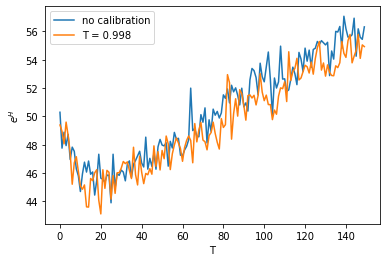

In [25]:
plt.plot(np.exp(ents[10:160]), label='no calibration')
plt.plot(np.exp(ents_temp[10:160]), label='T = 0.998')
plt.xlabel('T')
plt.ylabel('$e^H$')
plt.legend()

In [24]:
print(np.exp(ents[159]) - np.exp(ents[10]))
print(np.exp(ents_temp[159]) - np.exp(ents_temp[10]))

6.0317764
5.536766


In [27]:
np.load('../jobs/results/calibrate-full-h100/result.npz')['alpha']

array(0.03385988)

In [42]:
np.load('../jobs/results/calibrate-top1024-h100/result.npz')['alpha']

array(-0.02058726)

In [43]:
np.load('../jobs/results/calibrate-top2048-h100/result.npz')['alpha']

array(-0.02317655)

In [44]:
np.load('../jobs/results/calibrate-top4096-h100/result.npz')['alpha']

array(-0.02979463)

In [52]:
np.load('../jobs/results/cal512/result.npz')['alpha']

array(0.08590034)

In [47]:
np.load('../jobs/results/cal64/result.npz')['alpha']

array(0.40816477)

# 3. Different calibration values

In [3]:
ents64 = np.load('../jobs/results/gen-cal64-s1-nofilt/result.npz')['avg_ents'][0][10:]
ents512 = np.load('../jobs/results/gen-cal512-s1-nofilt/result.npz')['avg_ents'][0][10:]
ents = np.load('../jobs/results/entropy-s1/result.npz')['avg_ents'][0][10:]

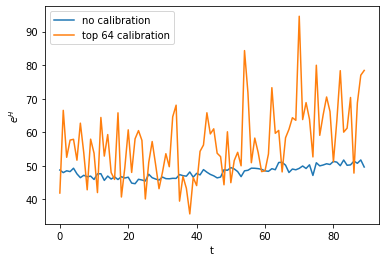

In [4]:
plt.plot(np.exp(ents), label='no calibration')
plt.plot(np.exp(ents64), label='top 64 calibration')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()

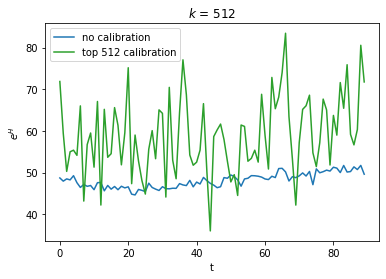

In [6]:
plt.plot(np.exp(ents), label='no calibration')
plt.plot(np.exp(ents512), label='top 512 calibration', color='C2')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.title('$k$ = 512')
plt.legend()

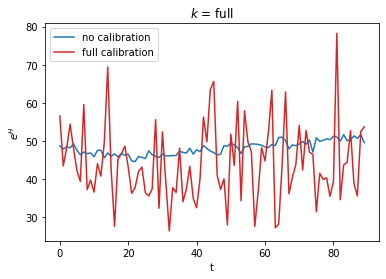

In [10]:
plt.plot(np.exp(ents), label='no calibration')
plt.plot(np.exp(tot[10:]), label='full calibration', color='C3')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.title('$k$ = full')
plt.legend()

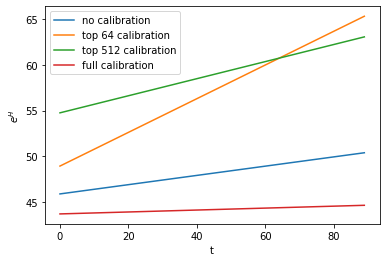

In [11]:
x = range(90)
z1 = np.polyfit(x, np.exp(ents), 1)
z40 = np.polyfit(x, np.exp(ents64), 1)
z512 = np.polyfit(x, np.exp(ents512), 1)
zfull = np.polyfit(x, np.exp(tot[10:]), 1)
plt.plot(np.poly1d(z1)(x), label='no calibration')
plt.plot(np.poly1d(z40)(x), label='top 64 calibration')
plt.plot(np.poly1d(z512)(x), label='top 512 calibration')
plt.plot(np.poly1d(zfull)(x), label='full calibration')
plt.title('')
plt.xlabel('t')
plt.ylabel('$e^H$')
plt.legend()

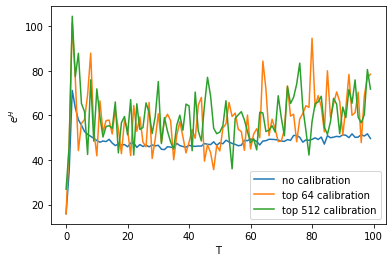

In [9]:
plt.plot(np.exp(ents), label='no calibration')
plt.plot(np.exp(ents64), label='top 64 calibration')
plt.plot(np.exp(ents512), label='top 512 calibration')
plt.plot(np.exp(tot), label='full calibration')
plt.xlabel('T')
plt.ylabel('$e^H$')
plt.legend()

In [8]:
d1 = np.load('../jobs/results/gen-cal-full1-a0.03/result.npz')['avg_ents'][0]
d2 = np.load('../jobs/results/gen-cal-full2-a0.03/result.npz')['avg_ents'][0]
d3 = np.load('../jobs/results/gen-cal-full3-a0.03/result.npz')['avg_ents'][0]
d4 = np.load('../jobs/results/gen-cal-full4-a0.03/result.npz')['avg_ents'][0]
d5 = np.load('../jobs/results/gen-cal-full5-a0.03/result.npz')['avg_ents'][0]
d6 = np.load('../jobs/results/gen-cal-full6-a0.03/result.npz')['avg_ents'][0]
d7 = np.load('../jobs/results/gen-cal-full7-a0.03/result.npz')['avg_ents'][0]
d8 = np.load('../jobs/results/gen-cal-full8-a0.03/result.npz')['avg_ents'][0]

In [9]:
tot = (d1 + d2 + d3 + d4 + d5 + d6 + d7 + d8) / 8